## Part A

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 12 plant species.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cv2 
from PIL import Image
from numpy import array
from numpy import asarray
from glob import glob
import imutils
import tensorflow as tf
from tensorflow import keras
import keras.utils as image

from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.model_selection import KFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Activation, Flatten,Dropout, Conv2D, MaxPooling2D ,GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import plot_model

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from zipfile import ZipFile
from sklearn.datasets import load_files 
from mpl_toolkits.axes_grid1 import ImageGrid


# GLOBAL VARIABLES
import warnings
warnings.filterwarnings("ignore");
%matplotlib inline

**Downloaded Aarhive file from Source: https://www.kaggle.com/c/plant-seedlings-classification/data given link**

In [2]:
import os
print("Working Directory:",os.getcwd())
# A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python
# Reading Archive File & Extracting all the members of the zip 
# into a specific location.

with ZipFile("C:\\Users\\farenrai\\Desktop\\mlworkspace\\computer-vision\\project\\plant-seedlings-classification.zip", 'r') as zipObject:
    zipObject.extractall(path="C:\\Users\\farenrai\\Desktop\\mlworkspace\\computer-vision\\project\\plant-seedings")

Working Directory: C:\Users\farenrai\Desktop\mlworkspace\computer-vision\project


In [3]:
## load files In Dataframe
from sklearn.datasets import load_files
train_folder=os.path.join(os.getcwd(),"plant-seedings","train")
test_folder=os.path.join(os.getcwd(),"plant-seedings","test")
print(train_folder)
print(test_folder)

C:\Users\farenrai\Desktop\mlworkspace\computer-vision\project\plant-seedings\train
C:\Users\farenrai\Desktop\mlworkspace\computer-vision\project\plant-seedings\test


In [4]:
labels_class = os.listdir(train_folder)
print(labels_class)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [5]:
from sklearn import preprocessing
lbl_ecdr = preprocessing.LabelEncoder()
lbl_ecdr.fit(labels_class)

LabelEncoder()

In [6]:
lbl_ecdr.transform(labels_class)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

<h3>Data Processsing Section</h3>

In [7]:
def data_process(folder_path):
    image_data = []
    labels_name = []
    target = [];
    images_list = [];
    dim=(128, 128)
    for idx, category in enumerate(labels_class):
        print(category, idx)
        catory_path = os.path.join(folder_path, category)
        image_list = os.listdir(os.path.join(folder_path, category))
        for img in  image_list:
            img_path = os.path.join(catory_path, img)
            #img = plt.imread(img_path)
            img = cv2.imread(img_path)
            rowImage = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            #Resizing Image
            resized_img = cv2.resize(img, dim)
            rowImageResize = cv2.resize(rowImage, dim)
            resized_img = resized_img.astype('float32') / 255
            #appending Image Data
            images_list.append(rowImageResize)
            image_data.append(resized_img)
            labels_name.append(category)
            target.append(idx)
            
    image_data = np.array(image_data)
    target = np.array(target)
    df_item = {"species": labels_name ,"image": images_list ,"target": target} 
    df = pd.DataFrame(df_item)
    return df, image_data, target

In [8]:
dim=128
testing_img_list  = list()
for dirname, _, filenames in os.walk(test_folder):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        resizedImage = img_data.resize((dim, dim))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255
        testing_img_list.append([resizedImage,filename])

X_test = np.zeros((len(testing_img_list), dim, dim, 3), dtype='float32')

In [9]:
X_test.shape

(794, 128, 128, 3)

In [10]:
image_df, image_data, target = data_process(train_folder)

Black-grass 0
Charlock 1
Cleavers 2
Common Chickweed 3
Common wheat 4
Fat Hen 5
Loose Silky-bent 6
Maize 7
Scentless Mayweed 8
Shepherds Purse 9
Small-flowered Cranesbill 10
Sugar beet 11


In [11]:
image_df

species                                              image  target
0     Black-grass  [[[24, 47, 77], [33, 54, 81], [45, 66, 89], [5...       0
1     Black-grass  [[[42, 48, 56], [50, 56, 66], [51, 55, 69], [5...       0
2     Black-grass  [[[22, 29, 49], [28, 36, 52], [22, 33, 51], [3...       0
3     Black-grass  [[[51, 84, 108], [55, 88, 111], [54, 88, 110],...       0
4     Black-grass  [[[167, 164, 164], [168, 168, 165], [162, 160,...       0
...           ...                                                ...     ...
4745   Sugar beet  [[[88, 83, 86], [83, 81, 81], [90, 87, 92], [1...      11
4746   Sugar beet  [[[36, 64, 93], [35, 64, 94], [18, 51, 83], [1...      11
4747   Sugar beet  [[[49, 63, 74], [50, 65, 75], [50, 65, 77], [4...      11
4748   Sugar beet  [[[145, 146, 147], [150, 150, 152], [151, 151,...      11
4749   Sugar beet  [[[69, 83, 96], [74, 88, 102], [73, 90, 101], ...      11

[4750 rows x 3 columns]

In [12]:
image_data.shape

(4750, 128, 128, 3)

In [13]:
target.shape

(4750,)

In [14]:
image_df.species.value_counts().values

array([654, 611, 516, 496, 475, 390, 385, 287, 263, 231, 221, 221],
      dtype=int64)

In [15]:
from sklearn.utils import shuffle
images,labels=shuffle(image_data,target,random_state=10)

In [16]:
print(f"Training image array shape : {len(images)}")
print(f"Training trainCategory labels : { len(labels)}")

Training image array shape : 4750
Training trainCategory labels : 4750


In [17]:
print("train Image shape", images.shape)
print("Train lables shape",labels.shape)

train Image shape (4750, 128, 128, 3)
Train lables shape (4750,)


[Text(0, 0, 'Black-grass'),
 Text(1, 0, 'Charlock'),
 Text(2, 0, 'Cleavers'),
 Text(3, 0, 'Common Chickweed'),
 Text(4, 0, 'Common wheat'),
 Text(5, 0, 'Fat Hen'),
 Text(6, 0, 'Loose Silky-bent'),
 Text(7, 0, 'Maize'),
 Text(8, 0, 'Scentless Mayweed'),
 Text(9, 0, 'Shepherds Purse'),
 Text(10, 0, 'Small-flowered Cranesbill'),
 Text(11, 0, 'Sugar beet')]

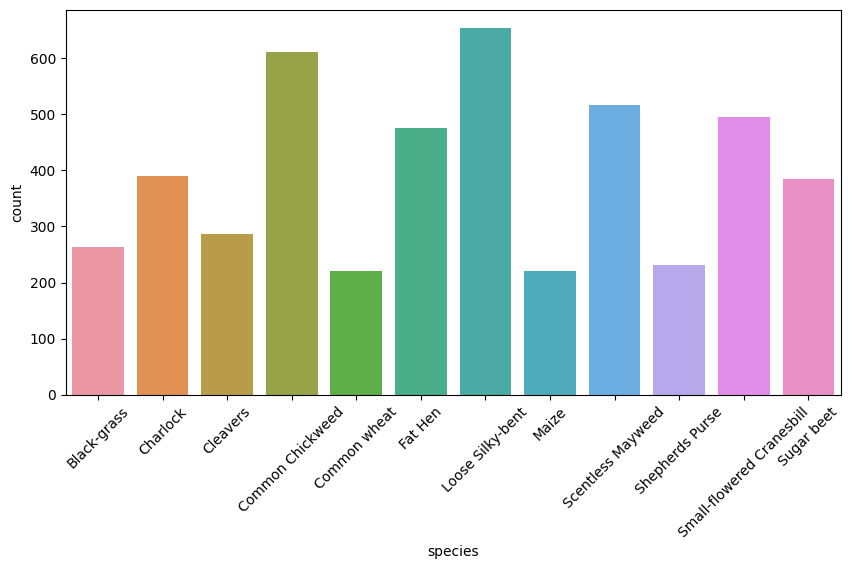

In [18]:
# Data Visualization Spicess
plt.figure(figsize=(10,5))
chart = sns.countplot( data=image_df, x='species')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

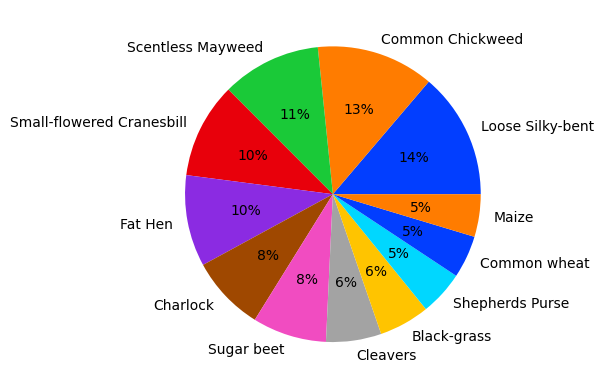

In [19]:
# Data Visualization Spicess 
palette_color = sns.color_palette('bright')
plt.pie(image_df.species.value_counts().values, labels=image_df.species.value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

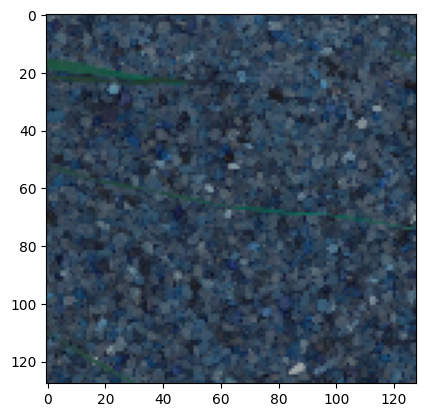

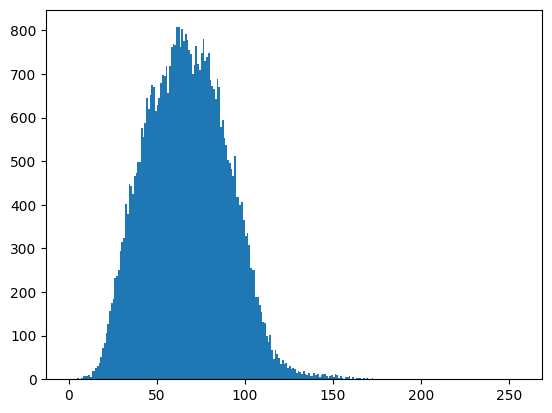

In [20]:
#Visulization Image Distribution 
plt.imshow(image_df.image[5])
plt.show()
#Image Data Distribution 
plt.hist(image_df.image[5].ravel(),256,[0,256])
plt.show()

In [21]:
code = {'Black-grass':0, 'Charlock':1, 'Cleavers':2, 'Common Chickweed':3, 'Common wheat':4, 'Fat Hen':5, 'Loose Silky-bent':6, 'Maize':7, 'Scentless Mayweed':8, 'Shepherds Purse':9, 'Small-flowered Cranesbill':10, 'Sugar beet':11}
def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y 
    else:
        for x,y in code.items():
            if n==y:
                return x

In [22]:
def showImages(image,label,typeofimage):
    plt.figure(figsize=(15,15))
    plt.suptitle("Labels with Image for "+typeofimage,fontsize=17)
    for n,i in  enumerate(list(np.random.randint(0,len(image),36))):
        plt.subplot(6,6,n+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.title(getcode(label[i]))
        
def ImageDistribution(image,label,typeofimage):
    plt.figure(figsize=(16,16))
    plt.suptitle("Image Distribution for "+typeofimage,fontsize=14)
    for n,i in  enumerate(list(np.random.randint(0,len(image),36))):
        plt.subplot(6,6,n+1)
        plt.hist(image[5].ravel(),256,[0,256])
        plt.axis("off")
        plt.title(getcode(label[i]))       

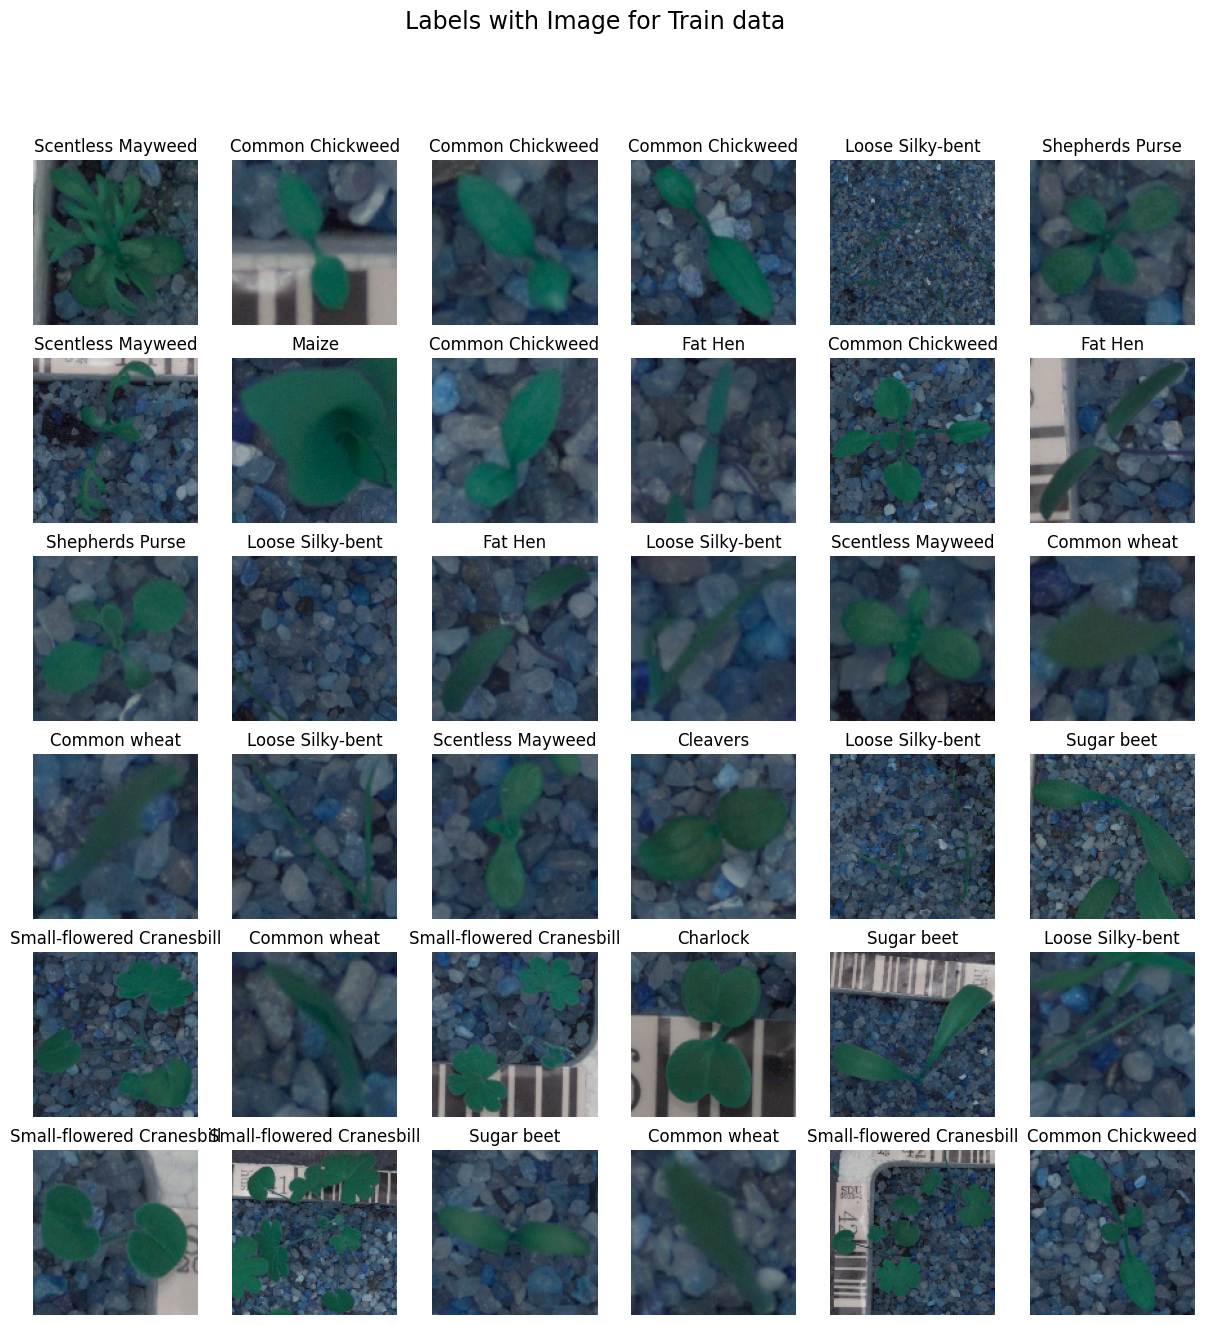

In [23]:
#C. Write a function that will select n random images and display images along with its species
showImages(images, labels, "Train data")

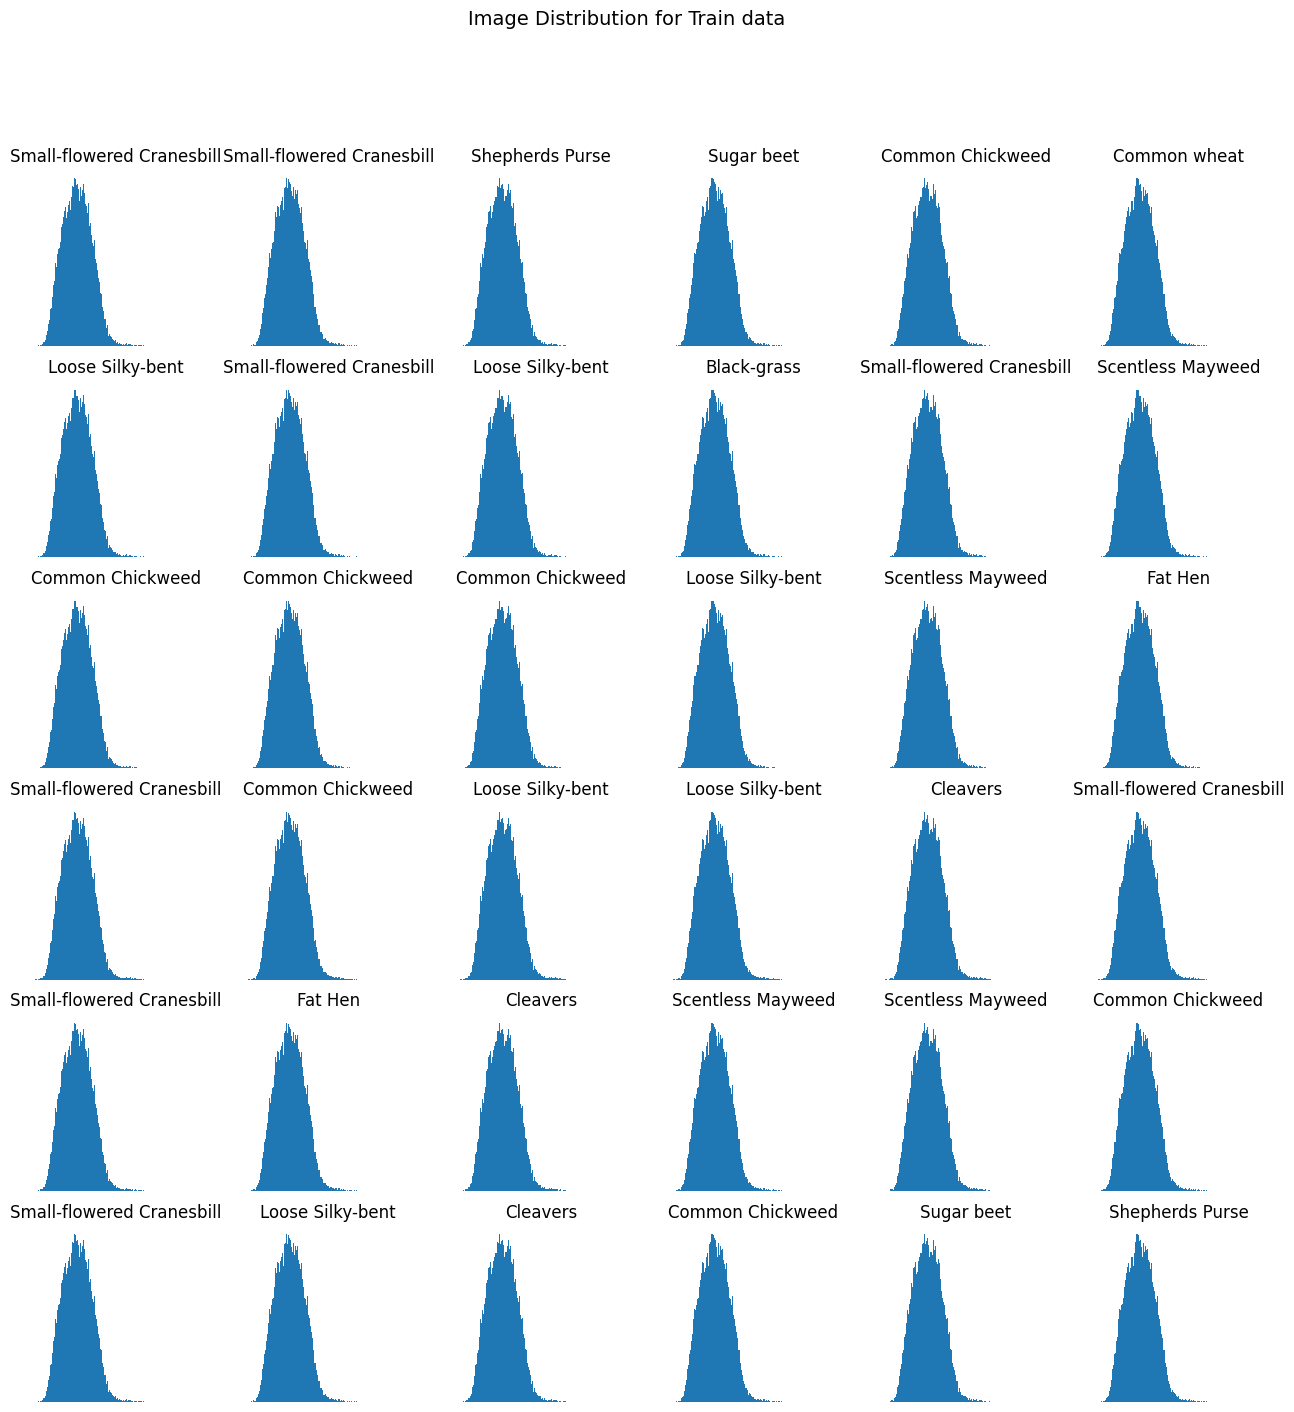

In [24]:
ImageDistribution(image_df.image, labels, "Train data")

In [25]:
#Label Encoding Data
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le = LabelEncoder()
le.fit(image_df['species'])
encoded_labels = le.transform(image_df['species'])
train_label = np_utils.to_categorical(encoded_labels)
xlabels = np_utils.to_categorical(labels)

## Data Spliting X and Y

In [26]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(images, labels, test_size=.20)

In [27]:
#Unifine test and train data and reshaping
train_x  = np.reshape(train_x, (-3, 128, 128, 3)) 
test_x  = np.reshape(test_x, (-3, 128, 128, 3)) 

In [28]:
#Normalization of the Image Data
train_x = train_x/255
test_x = test_x/255

In [29]:
len(labels_class)

12

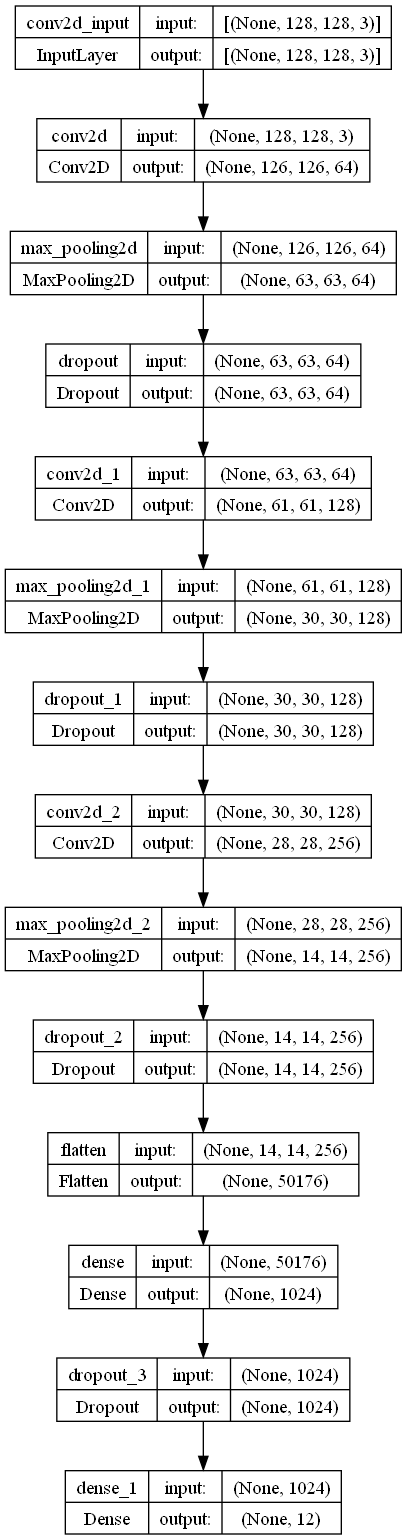

In [30]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(128,128,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(256,(3,3),activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(.25),
    keras.layers.Dense(len(labels_class),activation='softmax')
])
plot_model(model,to_file='model_visualization.png',show_shapes=True,show_layer_names=True)

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
adam = keras.optimizers.Adam(learning_rate=0.0001)

In [32]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 128)       0

In [34]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory(
    train_folder,
    target_size=(128,128),
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
    shuffle=True
);

Found 4750 images belonging to 12 classes.


In [35]:
#model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)
history = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=15);

148
Epoch 1/15
148/148 [==============================] - 204s 1s/step - loss: 2.4194 - accuracy: 0.2185
Epoch 2/15
148/148 [==============================] - 204s 1s/step - loss: 1.3521 - accuracy: 0.5244
Epoch 3/15
148/148 [==============================] - 201s 1s/step - loss: 0.9697 - accuracy: 0.6609
Epoch 4/15
148/148 [==============================] - 203s 1s/step - loss: 0.8140 - accuracy: 0.7192
Epoch 5/15
148/148 [==============================] - 202s 1s/step - loss: 0.6698 - accuracy: 0.7688
Epoch 6/15
148/148 [==============================] - 202s 1s/step - loss: 0.6073 - accuracy: 0.7880
Epoch 7/15
148/148 [==============================] - 201s 1s/step - loss: 0.5023 - accuracy: 0.8264
Epoch 8/15
148/148 [==============================] - 201s 1s/step - loss: 0.4332 - accuracy: 0.8508
Epoch 9/15
148/148 [==============================] - 201s 1s/step - loss: 0.3895 - accuracy: 0.8660
Epoch 10/15
148/148 [==============================] - 202s 1s/step - loss: 0.3448 - ac

<h3> Model Learning Evaluation </h3>

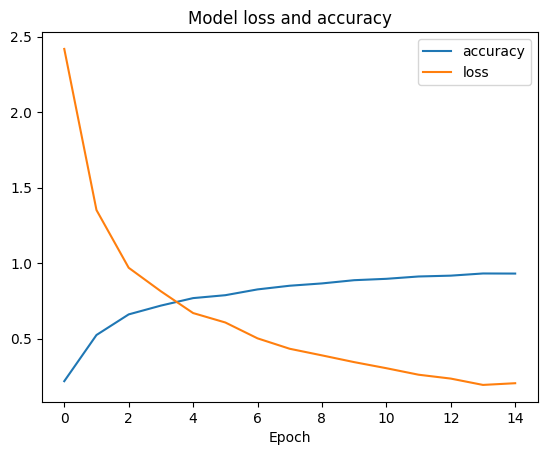

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model loss and accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy','loss'], loc='upper right')
plt.show();

<h3>Prediction On All Test data</h3>

In [37]:
predictions = model.predict(
    X_test,
    batch_size=None,
    verbose=0,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)
predictions=pd.DataFrame(predictions)

In [38]:
predictions

0         1         2         3         4         5         6   \
0    0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
1    0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
2    0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
3    0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
4    0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
..        ...       ...       ...       ...       ...       ...       ...   
789  0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
790  0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
791  0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
792  0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   
793  0.071733  0.000002  0.000163  0.000266  0.002871  0.048544  0.862501   

           7         8         9         10        11  
0    0.001004  0.000114  0.000006  0.012616  0.000181  
1    0.001004  0.000114  0.000006  0.012616  0.000181  
2    0.001004  0.000114  0.000006  0.012616  0.000181  
3    0.001004  0.000114  0.000006  0.012616  0.000181  
4    0.001004  0.000114  0.000006  0.012616  0.000181  
..        ...       ...       ...       ...       ...  
789  0.001004  0.000114  0.000006  0.012616  0.000181  
790  0.001004  0.000114  0.000006  0.012616  0.000181  
791  0.001004  0.000114  0.000006  0.012616  0.000181  
792  0.001004  0.000114  0.000006  0.012616  0.000181  
793  0.001004  0.000114  0.000006  0.012616  0.000181  

[794 rows x 12 columns]

In [39]:
inverse_label_map = dict()
for k,v in train_generator.class_indices.items():
    inverse_label_map[v] = k

In [40]:
pred_label_num = predictions.idxmax(axis=1)
pred_label_num_new = list()

for x in pred_label_num:
    y = inverse_label_map[x]
    pred_label_num_new.append(y)

pred_label_num_new = pd.DataFrame(pred_label_num_new)
print(pred_label_num_new[0])

0      Loose Silky-bent
1      Loose Silky-bent
2      Loose Silky-bent
3      Loose Silky-bent
4      Loose Silky-bent
             ...       
789    Loose Silky-bent
790    Loose Silky-bent
791    Loose Silky-bent
792    Loose Silky-bent
793    Loose Silky-bent
Name: 0, Length: 794, dtype: object


In [41]:
testImages = pd.DataFrame(testing_img_list)
pred=pd.DataFrame()
pred["file"] = testImages[1]
pred["species"] = pred_label_num_new[0]
pred.head()

file           species
0  0021e90e4.png  Loose Silky-bent
1  003d61042.png  Loose Silky-bent
2  007b3da8b.png  Loose Silky-bent
3  0086a6340.png  Loose Silky-bent
4  00c47e980.png  Loose Silky-bent

In [42]:
pred.to_csv('plant-seedings_test.csv',index = None, header=True)

<h3>Part B </h3>
<p>
<ul>   
    <li> <strong> DOMAIN: </strong>Botanical Research</li>
    <li> <strong> CONTEXT: </strong> 
University X is currently undergoing some research involving understanding the characteristics of flowers. They already have 
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo.
 </li>
 <li><strong> DATA DESCRIPTION: </strong>The dataset comprises of images from 17 plant species.</li>
 <li><strong> PROJECT OBJECTIVE:</strong>To experiment with various approaches to train an image classifier to predict type of flower from the image</li>
</ul>    
</p>


In [307]:
import tflearn.datasets.oxflower17 as oxflower17
import tflearn
import wget
import requests
import urllib
import tarfile
import urllib.request
import certifi
import ssl
import os
import cv2
import re
import shutil
from keras import models
from keras import layers
from keras import optimizers
from PIL import Image
ssl._create_default_https_context = ssl._create_unverified_context
#tf.keras.datasets.cifar10.load_data()

In [308]:
URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
print("Donload from  from this url ",URL)

Donload from  from this url  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz


In [309]:
certifi.where()
Context = ssl.create_default_context(cafile=certifi.where())
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["SSL_CERT_FILE"] = certifi.where()

In [310]:
#import tflearn.datasets.oxflower17 as oxflower17
from tflearn.datasets import oxflower17

In [311]:
X,y= oxflower17.load_data()

In [312]:
print(f'Shape of the Flower Image dataset: {X.shape}\n')
print(f'Number of Images in the dataset : {X.shape[0]}\n')
print(f'Shape of each Image in the dataset : {X.shape[1], X.shape[2], X.shape[3]}')

Shape of the Flower Image dataset: (1360, 224, 224, 3)

Number of Images in the dataset : 1360

Shape of each Image in the dataset : (224, 224, 3)


In [313]:
print("Number of Image X shape",X.shape)
print("Number of Image y shape",y.shape)

Number of Image X shape (1360, 224, 224, 3)
Number of Image y shape (1360, 17)


In [314]:
print(y.shape)
print(f'Count of each Class from y: {np.unique(y, return_counts=True)}')

(1360, 17)
Count of each Class from y: (array([0., 1.]), array([21760,  1360], dtype=int64))


In [315]:
label_class = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

In [316]:
print(label_class)

['Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot', 'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']


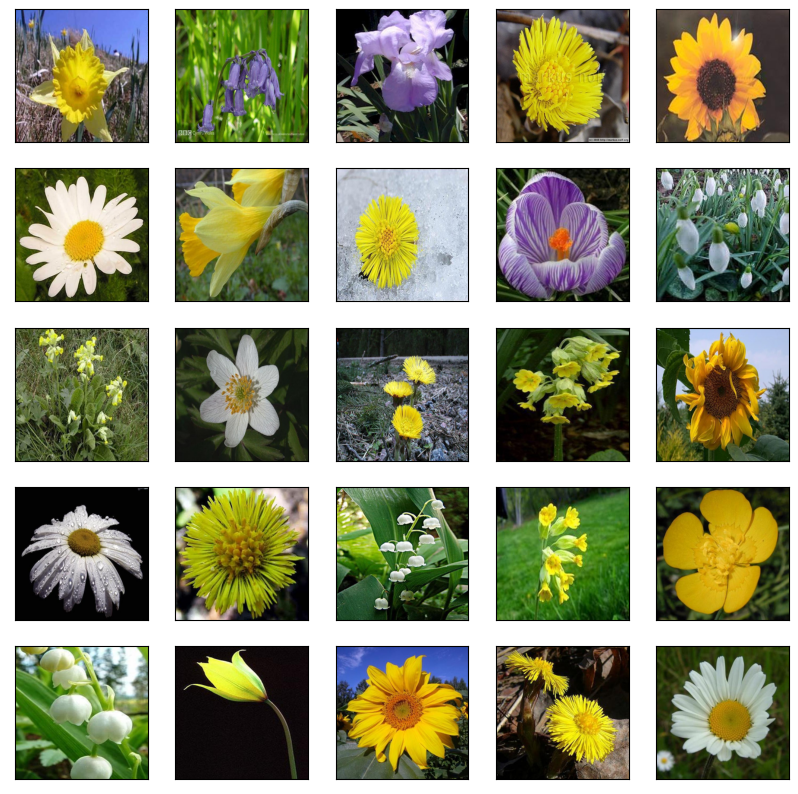

In [317]:
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i]) 

Text(0.5, 0, 'Gray Image')

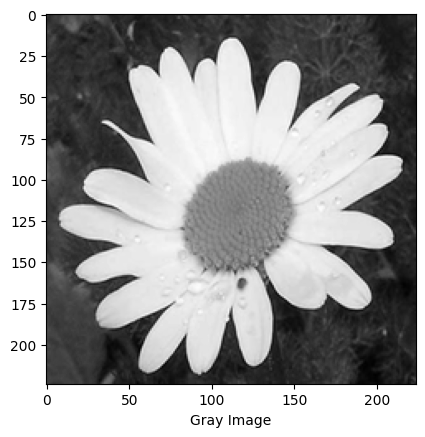

In [318]:
#Select any image from the dataset and assign it to a variable
img = X[5]
# convert the input image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray');
plt.xlabel("Gray Image")

Text(0.5, 0, 'Before Original')

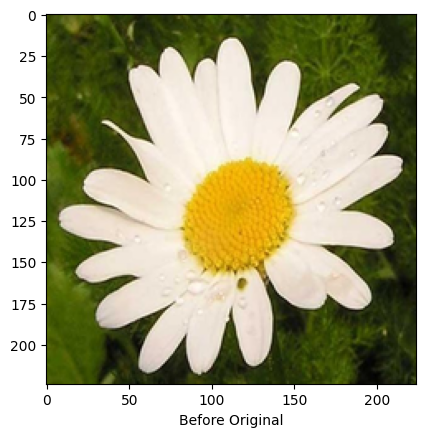

In [319]:
plt.imshow(X[5]);
plt.xlabel("Before Original")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


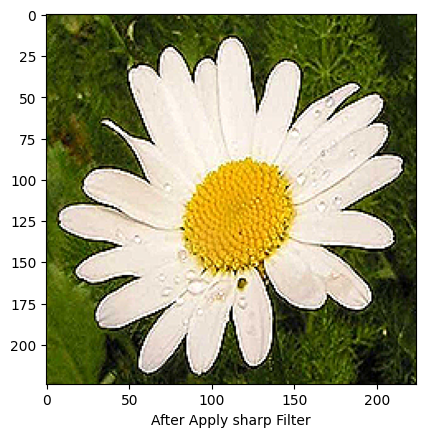

In [320]:
#Apply sharp Filer Color
kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
sharpened = cv2.filter2D(X[5], -1, kernel)
plt.imshow(sharpened);
plt.xlabel("After Apply sharp Filter");

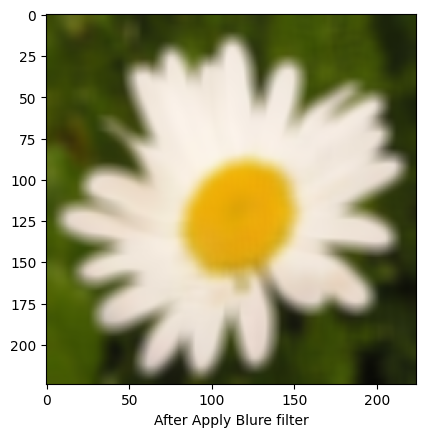

In [321]:
#Applying Blure filter 
blurImg = cv2.blur(X[5],(10,10)) 
plt.imshow(blurImg);
plt.xlabel("After Apply Blure filter");

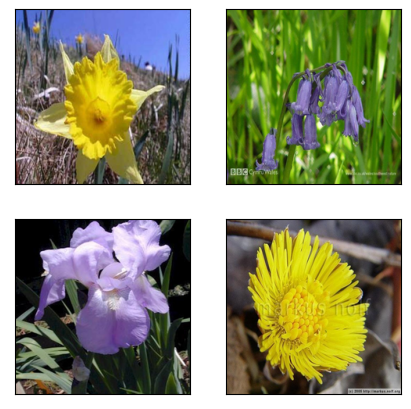

In [322]:
#Display all the 4 images from above questions besides each other to observe the difference
plt.figure(figsize=(5,5)) # plot 25 images
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i]) 

## Split the data into train and test with 80:20 proportion

In [323]:
# Train-Test Split
IMAGE_SIZE = 128
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [324]:
datapath=os.path.join(os.getcwd(),"17flowers","jpg")
print(datapath)

C:\Users\farenrai\Desktop\mlworkspace\computer-vision\project\17flowers\jpg


**Preprocess the data

In [325]:

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) 

train_batchsize = 100
val_batchsize = 10

train_generator = train_datagen.flow_from_directory( 
        datapath,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        datapath,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1360 images belonging to 17 classes.
Found 1360 images belonging to 17 classes.


**Model Building**

In [326]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [327]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [328]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
train_batchsize = 100
val_batchsize = 10

In [329]:
# Create the model
model = Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))
model.summary() 

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_72 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_54 (Dropout)        (None, 1024)              0         
                                                                 
 dense_73 (Dense)            (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 40,423,249
Non-trainable params: 0
_________________________________________________________________
